# 1. Specify the system type

In [1]:
import warnings
warnings.filterwarnings("ignore")

# specify the system
from RBG_Maxwell.Collision_database.select_system import which_system

plasma_system = 'Fusion_system'
which_system(plasma_system)

from RBG_Maxwell.Collision_database.Fusion_system.collision_type import collision_type_for_all_species

# 2. Specify the coefficient for unit conversion 

In [2]:
from RBG_Maxwell.Unit_conversion.main import determine_coefficient_for_unit_conversion, unit_conversion
import numpy as np

In [3]:
# here we use a pure electron system
# the relavant PIC code is given by Jian-Nan Chen

# give the quantities in SI
# the spatial grid is chosen to be dx=dy=dz=10**(-4) m
dx = dy = 10**(-5)
dz = 1.
dx_volume = dx*dy*dz 
# velocity is roughly 10**(6) m/s
v = 5*10**6

# charge
Q = 1.6*10**(-19) 

# momentum is roughly 10**(-30)kg*10**7m/s
momentum = 10**(-23)
# the momentum grid is set to be 
# npy=100, npx=npz=1, half_px=half_pz=half_py~10**(-23)
# hence dpy~10**(-26), dpx and dpz have no effect 
dp = (10**(-25)*10**(-23)*10**(-23))**(1/3)
dp_volume = dp*dp*dp
# the total number of particles are 5*10**(-13)/(1.6*10**(-19))
# put these particles in 71 spatial grids in z direction
# in 201 spatial grids in y direction
# and 100 momentum grids
# in each phase grid we have dn = 21.89755448111554
# the average value of distribution is roughly 
dn = 0.2189755448111554
f = dn/(dp**3*dx*dy*dz)
df = f

n_max = 5*10**(-13)/(1.6*10**(-19))

n_average = 5*10**(-13)/(1.6*10**(-19))/(10000)


v_max = 1.5*10**6

E = 1000
B = 5.5*10**(-5)

# time scale
dt = 10**(-13)

# Now find the coefficient
hbar, c, lambdax, epsilon0 = determine_coefficient_for_unit_conversion(dt, dx, dx_volume, dp, dp_volume,n_max, n_average, v_max, E, B)

Searching for proper scaling parameters...
This may take several minutes.


In [4]:
conversion_table = \
unit_conversion('SI_to_LHQCD', coef_J_to_E=lambdax, hbar=hbar, c=c, k=1., epsilon0=epsilon0)
conversion_table_reverse = \
unit_conversion('LHQCD_to_SI', coef_J_to_E=lambdax, hbar=hbar, c=c, k=1., epsilon0=epsilon0)

# 3. Specify the configurations for plasma evolution

In [5]:
# import the main class Plasma
from RBG_Maxwell.Plasma.main import Plasma

In [6]:
# time step, and spatial infinitesimals
# dt is 10**(-13) s, dx = dy = dz = 10**(-5) m
dt, dx, dy, dz = 10**(-13)*conversion_table['second'], \
                 10**(-5)*conversion_table['meter'], \
                 10**(-5)*conversion_table['meter'], \
                 10**(-5)*conversion_table['meter']

# we have only one type of particle e-
num_particle_species = 1

# treat the electron as classical particles
particle_type = np.array([0])

# masses, charges and degenericies are
masses, charges, degeneracy = np.array([9.11*10**(-31)*conversion_table['kilogram']]), \
                              np.array([-1.6*10**(-19)*conversion_table['Coulomb']]),\
                              np.array([1.])

# momentum grids
npx, npy, npz = 1, 201, 1

# half_px, half_py, half_pz
# momentum range for x and z direction are not import in this case
half_px, half_py, half_pz = np.array([9.11*10**(-31)*5*10**6*conversion_table['momentum']]), \
                            np.array([9.11*10**(-31)*5*10**6*conversion_table['momentum']]),\
                            np.array([9.11*10**(-31)*5*10**6*conversion_table['momentum']])

dpx, dpy, dpz = 2*half_px/npx, 2*half_py/npy, 2*half_pz/npz

# load the collision matrix
flavor, collision_type, particle_order = collision_type_for_all_species()
expected_collision_type = ['2TO2']

# 4. Specify the parallel configuration for plasma evolution

In [7]:
# number of spatial grids
# the maximum spatial gird is limited by CUDA, it's about nx*ny*nz~30000 for each card
nx_o, ny_o, nz_o = [1], [251], [111]

# value of the left boundary
# this is the 
x_left_bound_o, y_left_bound_o, z_left_bound_o = [-0.5*dx],\
                                                 [-125.5*dy],\
                                                 [-55.5*dz]

# number samples gives the number of sample points in MC integration
num_samples = 100

# Only specify one spatial region
number_regions = 1

# each spatial should use the full GPU, this number can be fractional if many regions are chosen
# and only one GPU is available
num_gpus_for_each_region = 0.1


# since only one region is specified, this will be empty
sub_region_relations = {'indicator': [[]],\
                        'position': [[]]}

# if np.ones are used, the boundaries are absorbing boundaries
# if np.zeros are used, it is reflection boundary
# numbers in between is also allowed
boundary_configuration = {}
for i_reg in range(number_regions):
    bound_x = np.ones([ny_o[i_reg], nz_o[i_reg]])
    bound_y = np.ones([nz_o[i_reg], nx_o[i_reg]])
    bound_z = np.ones([nx_o[i_reg], ny_o[i_reg]])
    boundary_configuration[i_reg] = (bound_x, bound_y, bound_z)

# 5. Specify the initial and boundary condition for plasma evolution

In [8]:
num_momentum_levels = 1

# iniital distribution function
f = {}
for i_reg in range(number_regions):
    f[i_reg] = np.zeros([num_momentum_levels, num_particle_species,\
                         nx_o[i_reg], ny_o[i_reg], nz_o[i_reg], npx, npy, npz])


# The initial velocity of the electrons is 1.87683*10**6 m/s, corresponds to the momentum value
# 9.11*10**(-31)*1.87683*10**6*conversion_table['momentum'] ~ 408.770512.
# The following code specifies the momentum grid index
dpy = 2*half_py/npy
a = 9.11*10**(-31)*1.87683*10**6*conversion_table['momentum']
ipy = [i for i in range(npy) if (-half_py+dpy*(i-0.5))<=a<=(-half_py+dpy*(i+1))][0]
dn_dv = 5*10**(-14)/(1.6*10**(-19))/(101*dx*dy*dz*dpx*dpy*dpz)

In [9]:
num_momentum_levels = 1

# iniital distribution function
f = {}
for i_reg in range(number_regions):
    f[i_reg] = np.zeros([num_momentum_levels, num_particle_species,\
                         nx_o[i_reg], ny_o[i_reg], nz_o[i_reg], npx, npy, npz])


# The initial velocity of the electrons is 1.87683*10**6 m/s, corresponds to the momentum value
# 9.11*10**(-31)*1.87683*10**6*conversion_table['momentum'] ~ 408.770512.
# The following code specifies the momentum grid index
dpy = 2*half_py/npy
a = 9.11*10**(-31)*1.87683*10**6*conversion_table['momentum']
ipy = [i for i in range(npy) if (-half_py+dpy*(i-0.5))<=a<=(-half_py+dpy*(i+1))][0]

'''
The total number of particles is 5*10**(-13)/(1.6*10**(-19)) ~ 31249999.999999996.
Put these particles in 101 grids, the number density of the particles is 
31249999.999999996/(101*dx*dy*dz) ~ 756837.0957070973 -> Delta_N/Delta_V.
The particles only possess the momentum region of size dpx*dpy*dpz,
hence the distribution function at each phase space grid is
756837.0957070973/(dpx*dpy*dpz) ~ 756837.0957070973/(2*half_px/npx*2*half_py/npy*2*half_pz/npz)
~ 1234.63197049
'''
dn_dv = 5*10**(-14)/(1.6*10**(-19))/(101*dx*dy*dz*dpx*dpy*dpz)

# nx=0, ny=90, nz=[30:41]
# e-, the first two indices correspond to num_momentum_levels=1, and num_particle_types=1
f[0][0, 0, 0,9,5:106,0,ipy,0] = dn_dv
# f[0][0, 0, 0,8,5:106,0,ipy,0] = 0.778801*dn_dv
# f[0][0, 0, 0,10,5:106,0,ipy,0] = 0.778801*dn_dv
# f[0][0, 0, 0,7,5:106,0,ipy,0] = 0.367879*dn_dv
# f[0][0, 0, 0,11,5:106,0,ipy,0] = 0.367879*dn_dv
# f[0][0, 0, 0,6,5:106,0,ipy,0] = 0.105399*dn_dv
# f[0][0, 0, 0,12,5:106,0,ipy,0] = 0.105399*dn_dv
# f[0][0, 0, 0,5,5:106,0,ipy,0] = 0.0183156*dn_dv
# f[0][0, 0, 0,13,5:106,0,ipy,0] = 0.0183156*dn_dv
# f[0][0, 0, 0,4,5:106,0,ipy,0] = 0.00193045*dn_dv
# f[0][0, 0, 0,14,5:106,0,ipy,0] = 0.00193045*dn_dv

# reshape the distribution function in different regions
for i_reg in range(number_regions):
    f[i_reg] = f[i_reg].reshape([num_momentum_levels, num_particle_species,\
                                 nx_o[i_reg]*ny_o[i_reg]*nz_o[i_reg]*npx*npy*npz])

'''
We add an external magnetic field of 10 T in the +y direction
'''
BBy = [10000*conversion_table['Tesla']*np.ones(nx_o[0]*ny_o[0]*nz_o[0])]
BEx, BEy, BEz, BBx, BBz = [0],[0],[0],[0],[0]

plasma = Plasma(f, dt, \
                nx_o, ny_o, nz_o, dx, dy, dz, boundary_configuration, \
                x_left_bound_o, y_left_bound_o, z_left_bound_o, \
                npx, npy, npz, half_px, half_py, half_pz,\
                masses, charges, sub_region_relations,\
                flavor, collision_type, particle_type,\
                degeneracy, expected_collision_type,\
                num_gpus_for_each_region,\
                hbar, c, lambdax, epsilon0, \
                num_samples = 100, drift_order = 2,\
                rho_J_method="raw", GPU_ids_for_each_region = ["2"])

[100]


2024-05-22 22:56:29,316	INFO worker.py:1622 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8272 


# 6. Perform evolution

In [10]:
n_step = 10001
number_rho = []
EM = []
charged_rho = []
dis = []
VT= []
DT = []
import time
start_time = time.time()
for i_time in range(n_step):  
    
    if i_time%200 == 0:
        dis.append(plasma.acquire_values("Distribution"))            
    plasma.proceed_one_step(i_time, n_step, processes = {'VT':1., 'DT':1., 'CT':0.},\
                            BEx = BEx, BEy = BEy, BEz = BEz, BBx = BBx, BBy = BBy, BBz = BBz)
    if i_time%200 == 0:     
        print('Updating the {}-th time step'.format(i_time))
        number_rho.append(plasma.acquire_values("number_rho/J"))
        charged_rho.append(plasma.acquire_values("Electric rho/J"))
    EM.append(plasma.acquire_values('EM fields on current region'))
end_time = time.time()

(Plasma_single_GPU pid=3021105) Using context GPU-664076ee-e781-2b13-0c9d-55cb6696c522 for region 0.
Updating the 0-th time step
Updating the 200-th time step
Updating the 400-th time step
Updating the 600-th time step
Updating the 800-th time step
Updating the 1000-th time step
Updating the 1200-th time step
Updating the 1400-th time step
Updating the 1600-th time step
Updating the 1800-th time step
Updating the 2000-th time step
Updating the 2200-th time step
Updating the 2400-th time step
Updating the 2600-th time step
Updating the 2800-th time step
Updating the 3000-th time step
Updating the 3200-th time step
Updating the 3400-th time step
Updating the 3600-th time step
Updating the 3800-th time step
Updating the 4000-th time step
Updating the 4200-th time step
Updating the 4400-th time step
Updating the 4600-th time step
Updating the 4800-th time step
Updating the 5000-th time step
Updating the 5200-th time step
Updating the 5400-th time step
Updating the 5600-th time step
Updatin

In [12]:
end_time-start_time

2150.1864891052246

# 7. Results

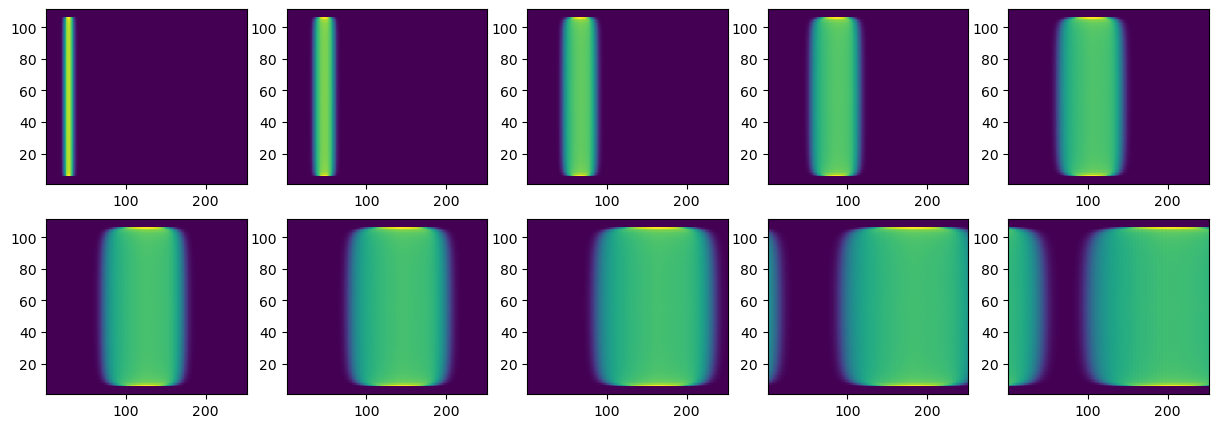

In [22]:
# spatial distribution
import matplotlib.pyplot as plt
xi, yi = np.mgrid[1:252:1,1:112:1]
fig, axes = plt.subplots(ncols=5, nrows=2, figsize = (15,5))
for jj in range(2):
    for kk in range(5):
        axes[jj,kk].pcolormesh(xi, yi, number_rho[(jj*5+kk+1)*5][0][0].reshape([nx_o[0],ny_o[0],nz_o[0]])[0])
        # axes[jj,kk].contour(xi, yi, data[jj*5+kk].sum(axis=-1)[0,1])

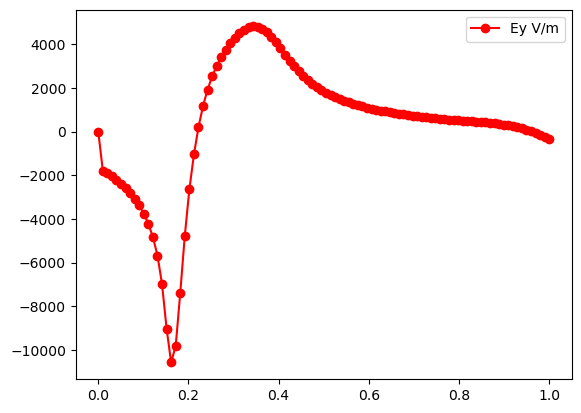

[0.0, 0.0101010101010101, 0.0202020202020202, 0.0303030303030303, 0.0404040404040404, 0.050505050505050504, 0.0606060606060606, 0.0707070707070707, 0.0808080808080808, 0.09090909090909091, 0.10101010101010101, 0.11111111111111112, 0.1212121212121212, 0.1313131313131313, 0.1414141414141414, 0.1515151515151515, 0.1616161616161616, 0.1717171717171717, 0.18181818181818182, 0.19191919191919193, 0.20202020202020202, 0.21212121212121213, 0.22222222222222224, 0.23232323232323232, 0.2424242424242424, 0.2525252525252525, 0.2626262626262626, 0.2727272727272727, 0.2828282828282828, 0.29292929292929293, 0.303030303030303, 0.31313131313131315, 0.3232323232323232, 0.3333333333333333, 0.3434343434343434, 0.3535353535353536, 0.36363636363636365, 0.37373737373737376, 0.38383838383838387, 0.3939393939393939, 0.40404040404040403, 0.41414141414141414, 0.42424242424242425, 0.43434343434343436, 0.4444444444444445, 0.4545454545454546, 0.46464646464646464, 0.47474747474747475, 0.4848484848484848, 0.49494949494

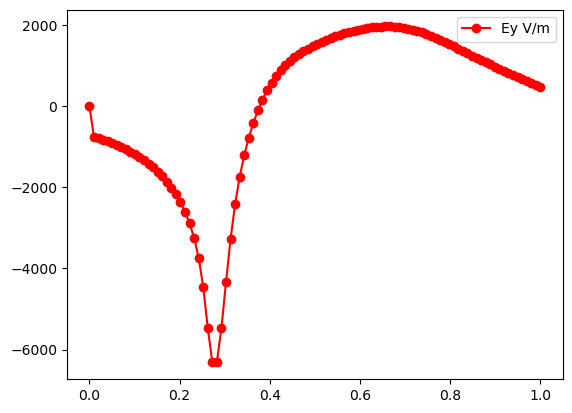

[0.0, 0.0101010101010101, 0.0202020202020202, 0.0303030303030303, 0.0404040404040404, 0.050505050505050504, 0.0606060606060606, 0.0707070707070707, 0.0808080808080808, 0.09090909090909091, 0.10101010101010101, 0.11111111111111112, 0.1212121212121212, 0.1313131313131313, 0.1414141414141414, 0.1515151515151515, 0.1616161616161616, 0.1717171717171717, 0.18181818181818182, 0.19191919191919193, 0.20202020202020202, 0.21212121212121213, 0.22222222222222224, 0.23232323232323232, 0.2424242424242424, 0.2525252525252525, 0.2626262626262626, 0.2727272727272727, 0.2828282828282828, 0.29292929292929293, 0.303030303030303, 0.31313131313131315, 0.3232323232323232, 0.3333333333333333, 0.3434343434343434, 0.3535353535353536, 0.36363636363636365, 0.37373737373737376, 0.38383838383838387, 0.3939393939393939, 0.40404040404040403, 0.41414141414141414, 0.42424242424242425, 0.43434343434343436, 0.4444444444444445, 0.4545454545454546, 0.46464646464646464, 0.47474747474747475, 0.4848484848484848, 0.49494949494

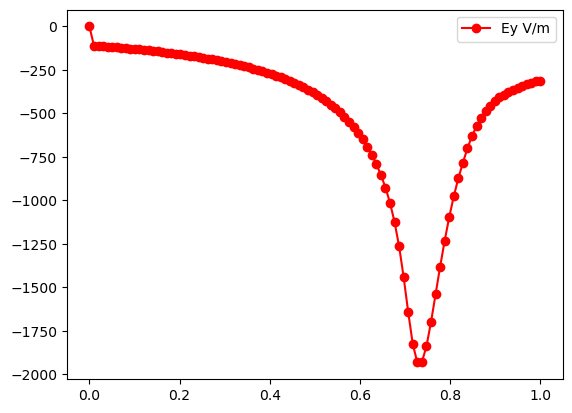

[0.0, 0.0101010101010101, 0.0202020202020202, 0.0303030303030303, 0.0404040404040404, 0.050505050505050504, 0.0606060606060606, 0.0707070707070707, 0.0808080808080808, 0.09090909090909091, 0.10101010101010101, 0.11111111111111112, 0.1212121212121212, 0.1313131313131313, 0.1414141414141414, 0.1515151515151515, 0.1616161616161616, 0.1717171717171717, 0.18181818181818182, 0.19191919191919193, 0.20202020202020202, 0.21212121212121213, 0.22222222222222224, 0.23232323232323232, 0.2424242424242424, 0.2525252525252525, 0.2626262626262626, 0.2727272727272727, 0.2828282828282828, 0.29292929292929293, 0.303030303030303, 0.31313131313131315, 0.3232323232323232, 0.3333333333333333, 0.3434343434343434, 0.3535353535353536, 0.36363636363636365, 0.37373737373737376, 0.38383838383838387, 0.3939393939393939, 0.40404040404040403, 0.41414141414141414, 0.42424242424242425, 0.43434343434343436, 0.4444444444444445, 0.4545454545454546, 0.46464646464646464, 0.47474747474747475, 0.4848484848484848, 0.49494949494

In [15]:
for ii in [50,80,210]:
    Ey = [EM[i][0][1]*conversion_table_reverse['TO_Volt/m'] for i in range(0,10000,100)]
    Ey = [Ey[i].reshape([nx_o[0],ny_o[0],nz_o[0]])[0,ii,55] for i in range(100)]
    # print(Ey)
    x = np.linspace(0,100,num=100)*dt*conversion_table_reverse['TO_second']*100*10**9
    plt.plot(x, Ey, color='red', marker='o', label='Ey V/m')
    plt.legend(loc='best')
    plt.show()
    print(x.tolist(),Ey)

In [23]:
import math
time = len(dis)
particle_number_ = np.zeros(time)
kinetic_energy_ = np.zeros(time)
momentum_ = np.zeros(time)
for t in range(time):
    f_temp = dis[t][0].reshape([num_momentum_levels, num_particle_species,nx_o[0],ny_o[0],nz_o[0],npx,npy,npz])
    particle_number_[t] = f_temp.sum()*dx*dy*dz*dpx[0]*dpy[0]*dpz[0]
    
    for ipx in range(npx):
        px = (ipx-npx/2+0.5)*dpx[0]
        for ipy in range(npy):
            py = (ipy-npy/2+0.5)*dpy[0]
            for ipz in range(npz):
                pz = (ipz-npz/2+0.5)*dpz[0]
                p2 = px**2+py**2+pz**2
                energy = math.sqrt(p2*c**2+masses[0]**2*c**4)
                kinetic_energy_[t] += f_temp[0,0,:,:,:,ipx,ipy,ipz].sum()*energy*dpy[0]*dpz[0]*dx*dy*dz*dpx[0]
                momentum_[t] += f_temp[0,0,:,:,:,ipx,ipy,ipz].sum()*py*dpy[0]*dpz[0]*dx*dy*dz*dpx[0]

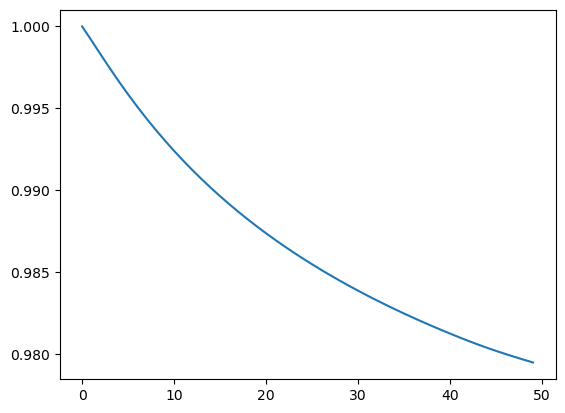

In [34]:
x = np.arange(len(particle_number_)-1)

plt.plot(x,momentum_[1:]/momentum_[1])